# Fashion-MNIST verification notebook

Load the dataset from the local `dataset` folder, run PCA, train Logistic Regression and K-Means, and visualize results.


In [4]:
import os
import gzip
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    ConfusionMatrixDisplay, classification_report
)
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')


In [5]:
def load_mnist_images(path):
    """Load MNIST / Fashion-MNIST images from .gz ubyte file."""
    with gzip.open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        if magic != 2051:
            raise ValueError(f"Invalid magic number {magic}, expected 2051")
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        buffer = f.read()
        data = np.frombuffer(buffer, dtype=np.uint8)
        return data.reshape(num_images, rows * cols)


def load_mnist_labels(path):
    """Load MNIST / Fashion-MNIST labels from .gz ubyte file."""
    with gzip.open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        if magic != 2049:
            raise ValueError(f"Invalid magic number {magic}, expected 2049")
        num_labels = int.from_bytes(f.read(4), 'big')
        buffer = f.read()
        return np.frombuffer(buffer, dtype=np.uint8)


In [ ]:
print("=" * 60)
print("LOADING FASHION-MNIST DATASET")
print("=" * 60)

# In a notebook, __file__ is not defined, so just use a path
# relative to the notebook location (MINIST/verify_mnist.ipynb)
# where the dataset is in MINIST/dataset

data_path = 'dataset'

X_train = load_mnist_images(os.path.join(data_path, 'train-images-idx3-ubyte.gz'))
y_train = load_mnist_labels(os.path.join(data_path, 'train-labels-idx1-ubyte.gz'))
X_test  = load_mnist_images(os.path.join(data_path, 't10k-images-idx3-ubyte.gz'))
y_test  = load_mnist_labels(os.path.join(data_path, 't10k-labels-idx1-ubyte.gz'))

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# Normalize pixels to 0-1
X_train = X_train / 255.0
X_test  = X_test / 255.0

# Combine and filter to first 5 classes
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
mask = y < 5
X, y = X[mask], y[mask]

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=5000, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=6000, random_state=42, stratify=y_train_val)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']

print(f"\nDataset Split:")
print(f"  Training:   {X_train.shape[0]:,} samples")
print(f"  Validation: {X_val.shape[0]:,} samples")
print(f"  Test:       {X_test.shape[0]:,} samples")
print(f"  Classes:    {len(class_names)} ({', '.join(class_names)})")


LOADING FASHION-MNIST DATASET
Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)

Dataset Split:
  Training:   24,000 samples
  Validation: 6,000 samples
  Test:       5,000 samples
  Classes:    5 (T-shirt/top, Trouser, Pullover, Dress, Coat)



APPLYING PCA DIMENSIONALITY REDUCTION

Original dimensions: 784
Reduced dimensions:  100
Variance explained:  93.60%


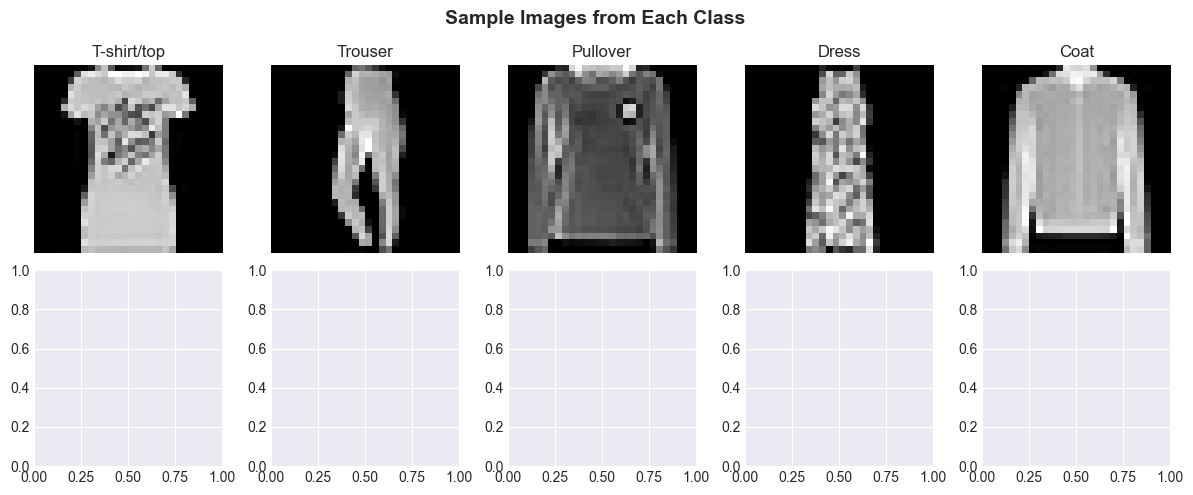

In [7]:
print("\n" + "=" * 60)
print("APPLYING PCA DIMENSIONALITY REDUCTION")
print("=" * 60)

pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"\nOriginal dimensions: {X_train.shape[1]}")
print(f"Reduced dimensions:  {X_train_pca.shape[1]}")
print(f"Variance explained:  {pca.explained_variance_ratio_.sum():.2%}")

# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold')
for i in range(len(class_names)):
    ax = axes.flat[i]
    class_indices = np.where(y_train == i)[0]
    if len(class_indices) == 0:
        continue
    idx = class_indices[0]
    ax.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')
plt.tight_layout()
plt.show()



LOGISTIC REGRESSION MODEL

Performing Grid Search for optimal hyperparameters...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters: {'C': 1, 'solver': 'lbfgs'}
Best CV Accuracy: 0.8859

Test Accuracy:       0.8848

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.91      0.91      0.91      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.84      0.80      0.82      1000
       Dress       0.86      0.88      0.87      1000
        Coat       0.83      0.87      0.85      1000

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000


Generating loss curve...


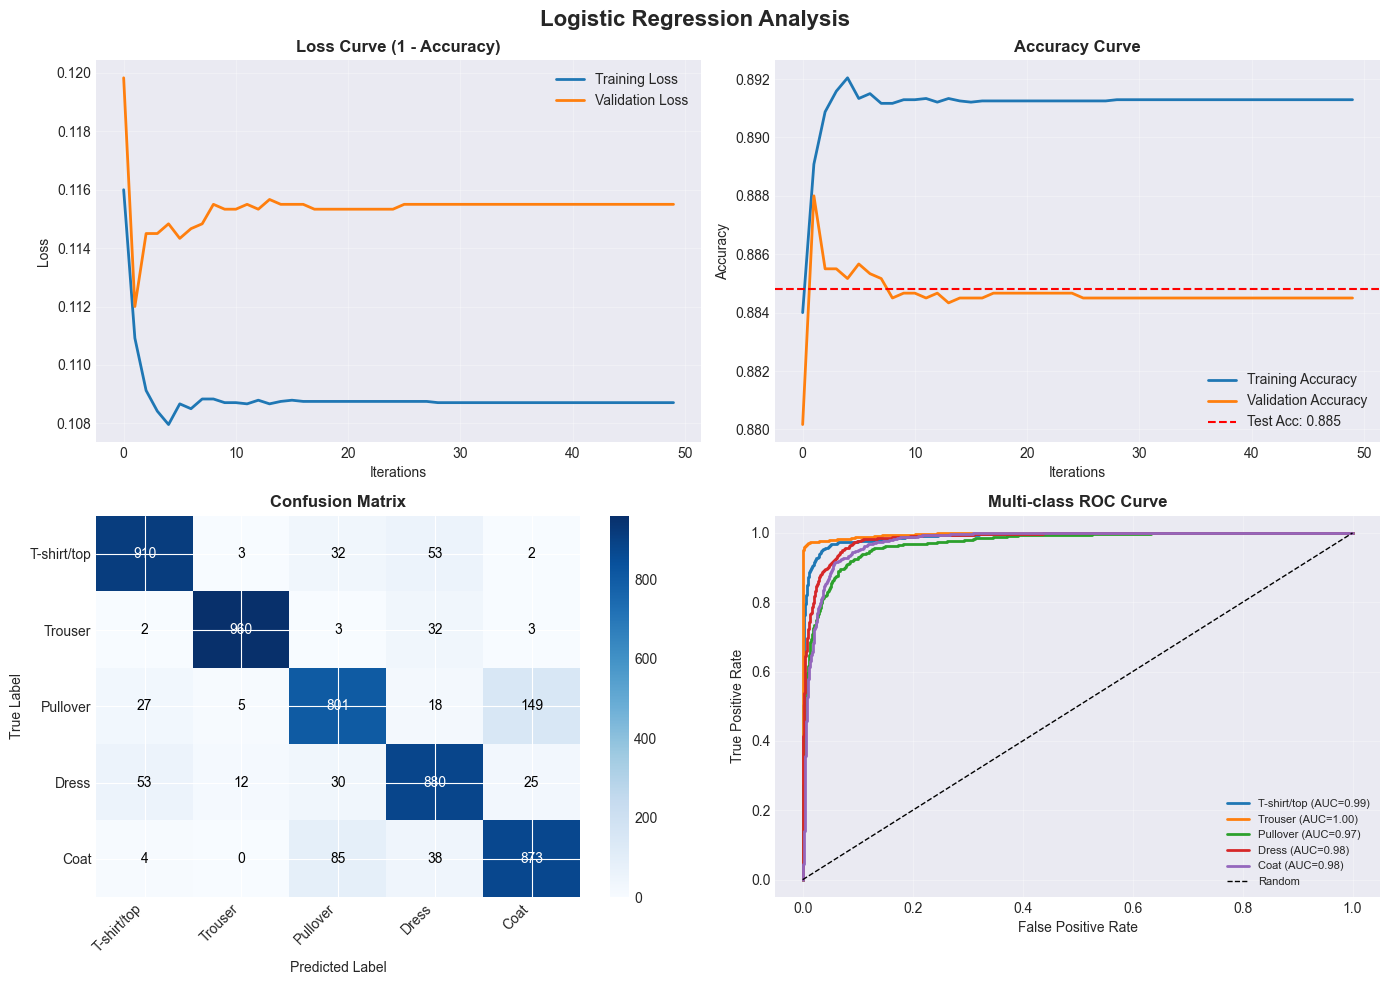

In [8]:
print("\n" + "=" * 60)
print("LOGISTIC REGRESSION MODEL")
print("=" * 60)

# Hyperparameter tuning
print("\nPerforming Grid Search for optimal hyperparameters...")
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'saga']}
logreg = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_pca, y_train)

print(f"\nBest Parameters: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

# Train final model on train + validation
best_logreg = grid.best_estimator_
X_combined = np.vstack((X_train_pca, X_val_pca))
y_combined = np.hstack((y_train, y_val))
best_logreg.fit(X_combined, y_combined)

# Predictions
y_pred_log = best_logreg.predict(X_test_pca)
y_proba_log = best_logreg.predict_proba(X_test_pca)
acc_log = accuracy_score(y_test, y_pred_log)

print(f"\n{'Test Accuracy:':<20} {acc_log:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=class_names))

# Loss curve (training progression)
print("\nGenerating loss curve...")
train_losses, val_losses = [], []
train_accs, val_accs = [], []

logreg_curve = LogisticRegression(
    multi_class='multinomial', solver='saga',
    C=grid.best_params_['C'], max_iter=1,
    warm_start=True, random_state=42
)

for epoch in range(1, 51):
    logreg_curve.max_iter = epoch
    logreg_curve.fit(X_train_pca, y_train)

    train_acc = logreg_curve.score(X_train_pca, y_train)
    val_acc = logreg_curve.score(X_val_pca, y_val)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(1 - train_acc)
    val_losses.append(1 - val_acc)

# Visualizations for Logistic Regression
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Logistic Regression Analysis', fontsize=16, fontweight='bold')

# Loss curve
axes[0, 0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0, 0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Loss Curve (1 - Accuracy)', fontweight='bold')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curve
axes[0, 1].plot(train_accs, label='Training Accuracy', linewidth=2)
axes[0, 1].plot(val_accs, label='Validation Accuracy', linewidth=2)
axes[0, 1].axhline(y=acc_log, color='r', linestyle='--', label=f'Test Acc: {acc_log:.3f}')
axes[0, 1].set_title('Accuracy Curve', fontweight='bold')
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log)
im = axes[1, 0].imshow(cm_log, cmap='Blues', aspect='auto')
axes[1, 0].set_title('Confusion Matrix', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xticks(range(5))
axes[1, 0].set_yticks(range(5))
axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 0].set_yticklabels(class_names)
for i in range(5):
    for j in range(5):
        axes[1, 0].text(j, i, str(cm_log[i, j]), ha='center', va='center',
                        color='white' if cm_log[i, j] > cm_log.max() / 2 else 'black')
plt.colorbar(im, ax=axes[1, 0])

# ROC Curve
y_test_bin = pd.get_dummies(y_test)
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_proba_log[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, label=f'{class_names[i]} (AUC={roc_auc:.2f})', linewidth=2)

axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1, 1].set_title('Multi-class ROC Curve', fontweight='bold')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend(loc='lower right', fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



K-MEANS CLUSTERING MODEL

Fitting K-Means with 5 clusters...

Cluster to Label Mapping: {0: np.int64(1), 1: np.int64(4), 2: np.int64(3), 3: np.int64(2), 4: np.int64(0)}

Test Accuracy:       0.5572

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.96      0.51      0.66      1000
     Trouser       0.73      0.86      0.79      1000
    Pullover       0.28      0.32      0.30      1000
       Dress       0.55      0.45      0.50      1000
        Coat       0.48      0.66      0.55      1000

    accuracy                           0.56      5000
   macro avg       0.60      0.56      0.56      5000
weighted avg       0.60      0.56      0.56      5000


Generating inertia curve...


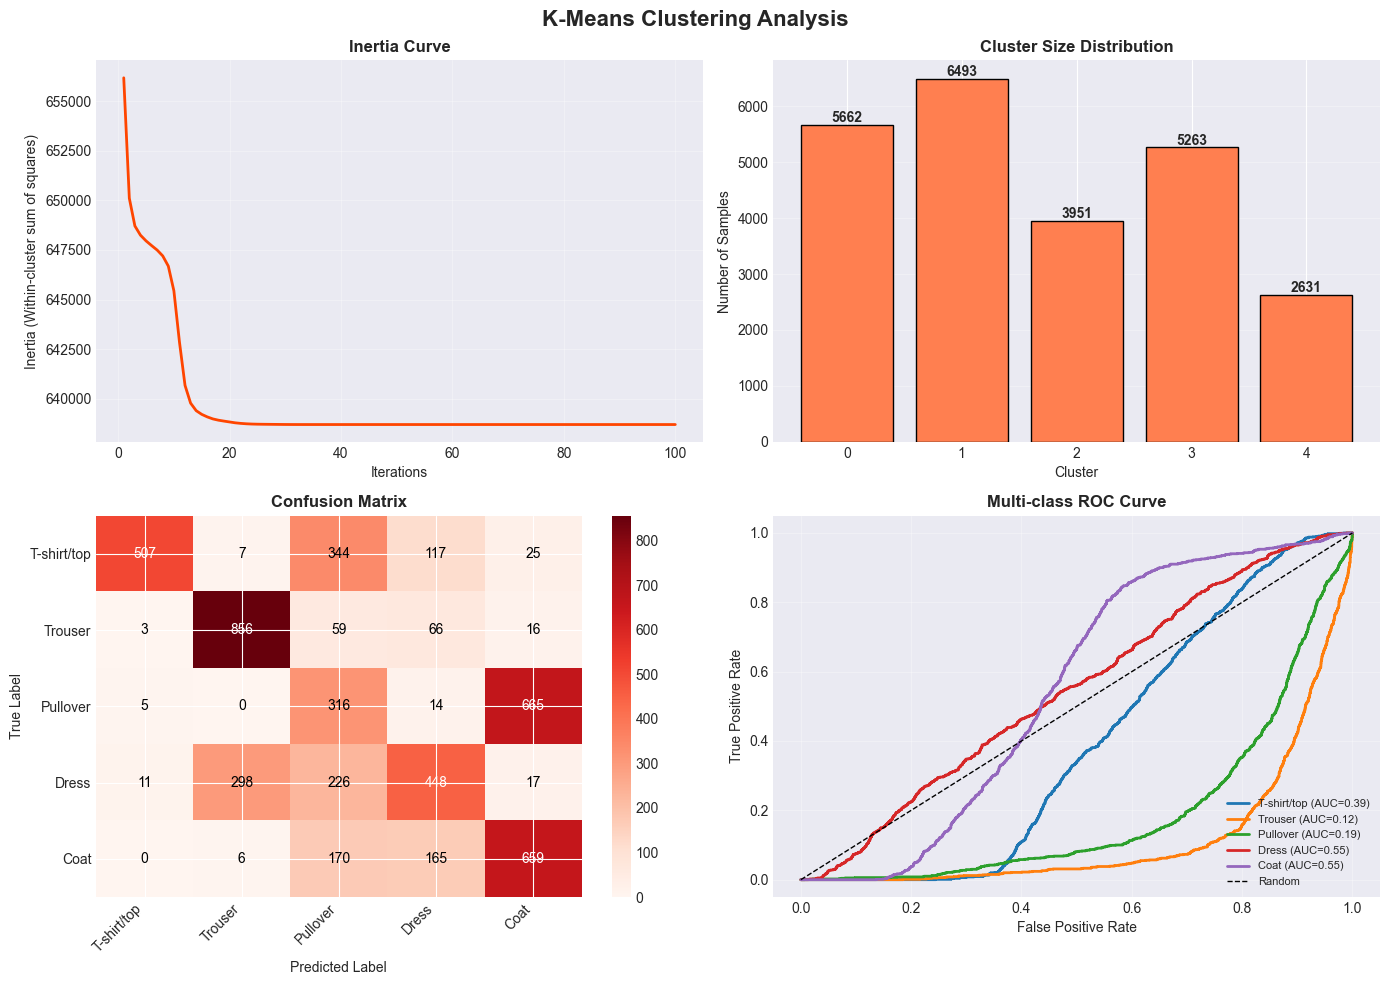


MODEL COMPARISON SUMMARY

               Model  Test Accuracy         Type
Logistic Regression         0.8848   Supervised
            K-Means         0.5572 Unsupervised


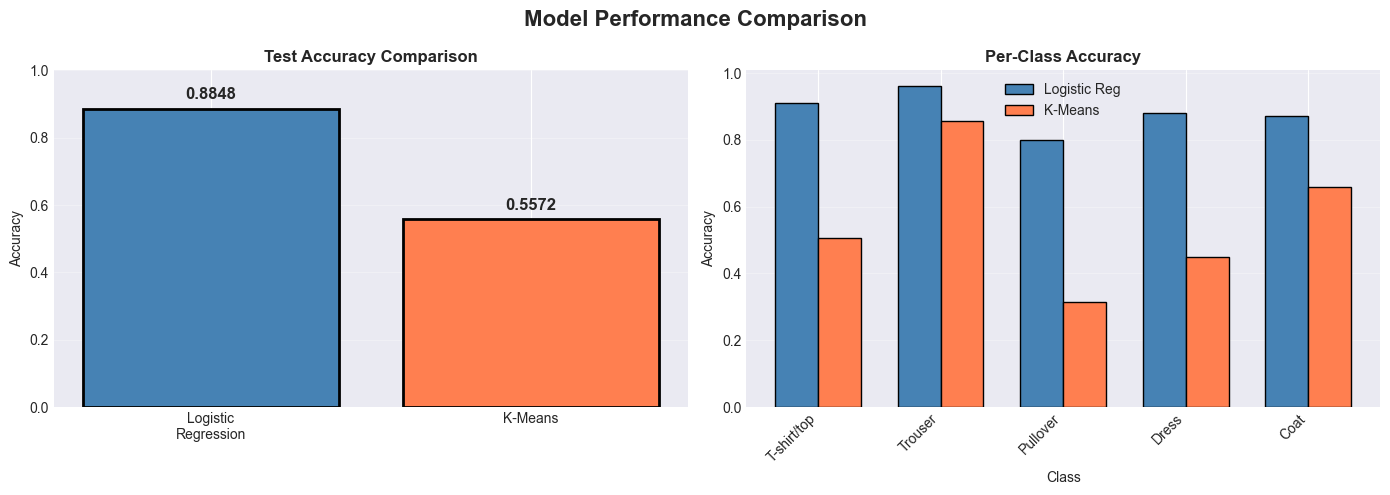


ANALYSIS COMPLETE


In [9]:
print("\n" + "=" * 60)
print("K-MEANS CLUSTERING MODEL")
print("=" * 60)

print("\nFitting K-Means with 5 clusters...")
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_train_pca)

# Map clusters to labels
cluster_map = {}
for cluster in range(5):
    mask_cluster = (kmeans.labels_ == cluster)
    if mask_cluster.sum() > 0:
        cluster_map[cluster] = np.bincount(y_train[mask_cluster]).argmax()

print(f"\nCluster to Label Mapping: {cluster_map}")

# Predictions
cluster_pred = kmeans.predict(X_test_pca)
y_pred_kmeans = np.array([cluster_map.get(c, 0) for c in cluster_pred])
acc_kmeans = accuracy_score(y_test, y_pred_kmeans)

print(f"\n{'Test Accuracy:':<20} {acc_kmeans:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_kmeans, target_names=class_names))

# Inertia progression
print("\nGenerating inertia curve...")
inertias = []
for i in range(1, 101):
    km = KMeans(n_clusters=5, max_iter=i, n_init=1, random_state=42)
    km.fit(X_train_pca)
    inertias.append(km.inertia_)

# Distance-based probabilities for ROC
dists = kmeans.transform(X_test_pca)
scores_km = np.exp(-dists / dists.mean())
scores_km = scores_km / scores_km.sum(axis=1, keepdims=True)

# Visualizations for K-Means
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('K-Means Clustering Analysis', fontsize=16, fontweight='bold')

# Inertia curve
axes[0, 0].plot(range(1, 101), inertias, linewidth=2, color='orangered')
axes[0, 0].set_title('Inertia Curve', fontweight='bold')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0, 0].grid(True, alpha=0.3)

# Cluster sizes
cluster_sizes = [np.sum(kmeans.labels_ == i) for i in range(5)]
axes[0, 1].bar(range(5), cluster_sizes, color='coral', edgecolor='black')
axes[0, 1].set_title('Cluster Size Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Number of Samples')
axes[0, 1].set_xticks(range(5))
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(cluster_sizes):
    axes[0, 1].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Confusion Matrix
cm_km = confusion_matrix(y_test, y_pred_kmeans)
im = axes[1, 0].imshow(cm_km, cmap='Reds', aspect='auto')
axes[1, 0].set_title('Confusion Matrix', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xticks(range(5))
axes[1, 0].set_yticks(range(5))
axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 0].set_yticklabels(class_names)
for i in range(5):
    for j in range(5):
        axes[1, 0].text(j, i, str(cm_km[i, j]), ha='center', va='center',
                        color='white' if cm_km[i, j] > cm_km.max() / 2 else 'black')
plt.colorbar(im, ax=axes[1, 0])

# ROC Curve
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], scores_km[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, label=f'{class_names[i]} (AUC={roc_auc:.2f})', linewidth=2)

axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1, 1].set_title('Multi-class ROC Curve', fontweight='bold')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend(loc='lower right', fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

comparison_data = {
    'Model': ['Logistic Regression', 'K-Means'],
    'Test Accuracy': [acc_log, acc_kmeans],
    'Type': ['Supervised', 'Unsupervised']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
models = ['Logistic\nRegression', 'K-Means']
accuracies = [acc_log, acc_kmeans]
colors = ['steelblue', 'coral']

bars = axes[0].bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
axes[0].set_title('Test Accuracy Comparison', fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2., height + 0.02,
                 f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Per-class accuracy
class_acc_log = []
class_acc_km = []
for i in range(5):
    mask = y_test == i
    class_acc_log.append(accuracy_score(y_test[mask], y_pred_log[mask]))
    class_acc_km.append(accuracy_score(y_test[mask], y_pred_kmeans[mask]))

x = np.arange(len(class_names))
width = 0.35
axes[1].bar(x - width / 2, class_acc_log, width, label='Logistic Reg', color='steelblue', edgecolor='black')
axes[1].bar(x + width / 2, class_acc_km, width, label='K-Means', color='coral', edgecolor='black')
axes[1].set_title('Per-Class Accuracy', fontweight='bold')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
